In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [87]:
# data preprocessing
df = pd.read_csv('GOOG.csv')
df_sp500 = pd.read_csv('SP500.csv')
df = df[['Date','Adj Close']]
df.rename(columns={'Adj Close': 'GOOG'}, inplace=True)
df['SP500'] = df_sp500['Adj Close']
df.set_index('Date',inplace=True)
df.head()

,GOOG,SP500
Date,,
2018-10-09,56.941002,2880.340088
2018-10-10,54.061001,2785.679932
2018-10-11,53.966000,2728.370117
2018-10-12,55.504002,2767.129883
2018-10-15,54.612499,2750.790039


In [88]:
# check if there's missing value
df.isna().any()

GOOG     False
SP500    False
dtype: bool

In [89]:
# check if data stationary
print('GOOG')
print(adfuller(df['GOOG'])[0])
print(adfuller(df['GOOG'])[1])
print('SP500')
print(adfuller(df['SP500'])[0])
print(adfuller(df['SP500'])[1])
# adjected close price of both GOOG and SP500 are non-stationary

GOOG
-0.9808129795408335
0.7601978450028577
SP500
-1.4343430811350601
0.5657054245831619


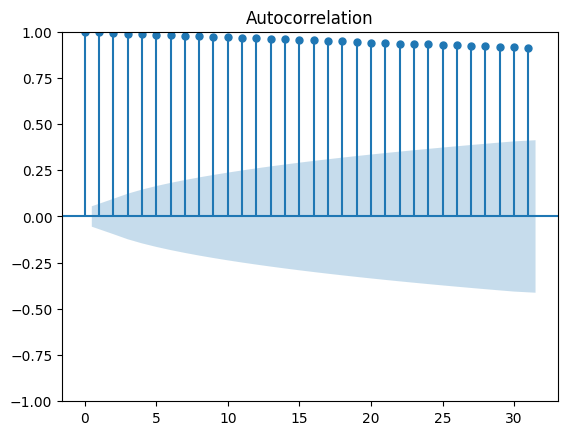

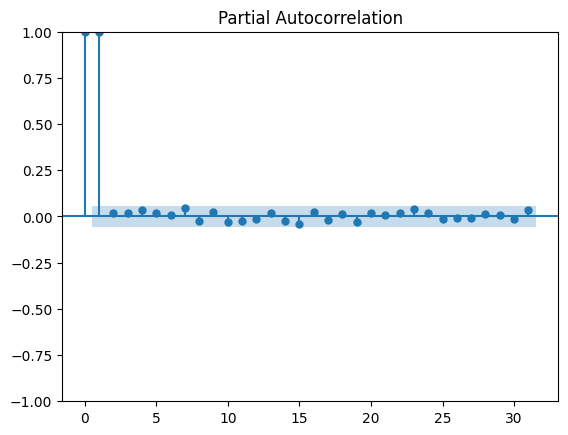

In [90]:
# GOOG ACF, PACF
plot_acf(df['GOOG'])
plot_pacf(df['GOOG'])
plt.show()

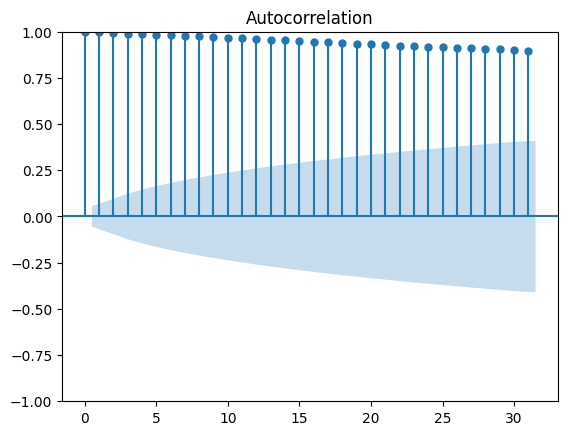

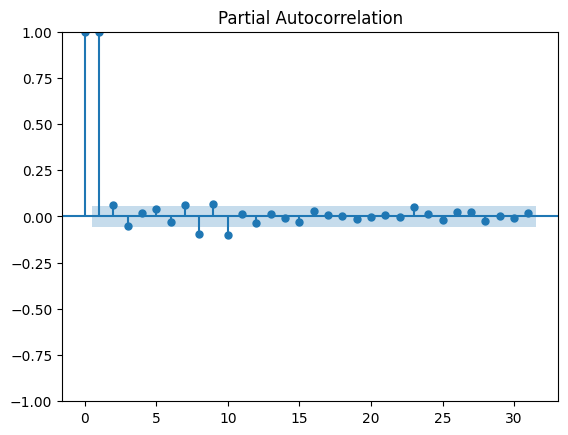

In [91]:
# SP500 ACF, PACF
plot_acf(df['SP500'])
plot_pacf(df['SP500'])
plt.show()

In [92]:
# check if data stationary after differencing
df['GOOG_d1'] = df['GOOG'].diff()
print('GOOG')
print(adfuller(df['GOOG_d1'].dropna())[0])
print(adfuller(df['GOOG_d1'].dropna())[1])
df['SP500_d1'] = df['SP500'].diff()
print('SP500')
print(adfuller(df['SP500_d1'].dropna())[0])
print(adfuller(df['SP500_d1'].dropna())[1])
# now the data is stationary; we will use d=1

GOOG
-37.20489705724011
0.0
SP500
-10.931185621275416
9.813880972694229e-20


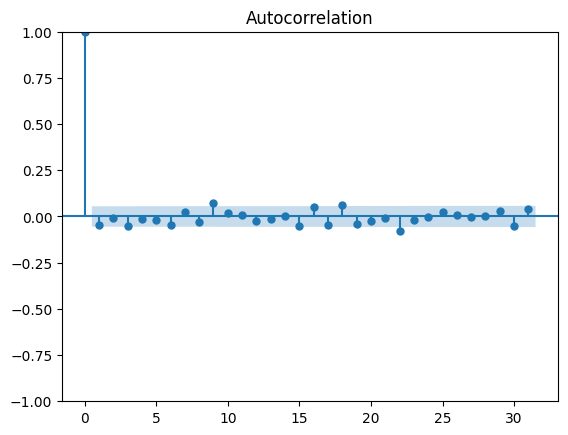

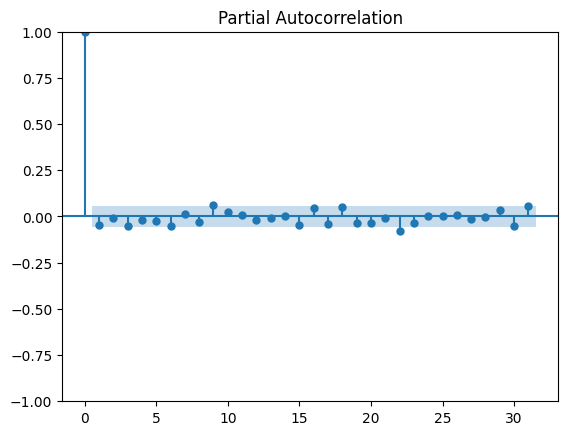

In [93]:
plot_acf(df['GOOG_d1'].dropna())
plot_pacf(df['GOOG_d1'].dropna())
plt.show()

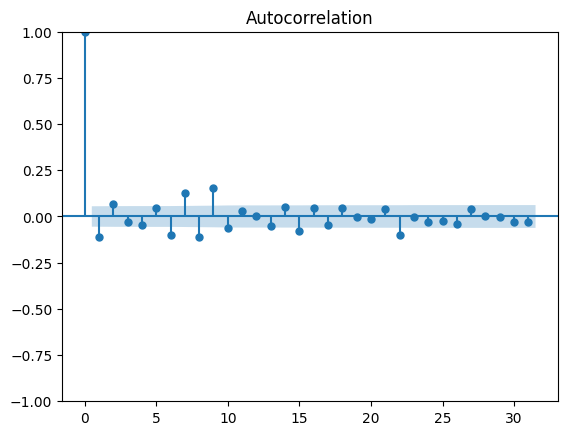

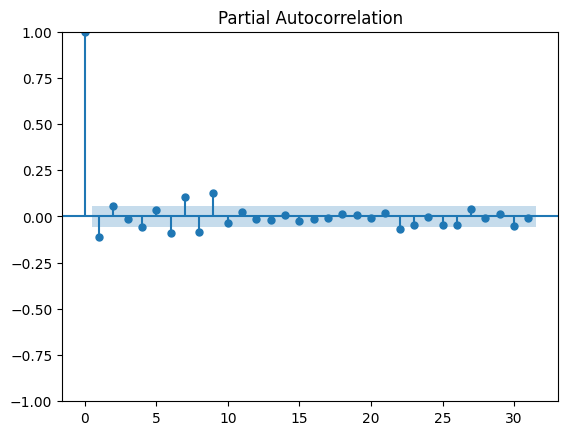

In [94]:
plot_acf(df['SP500_d1'].dropna())
plot_pacf(df['SP500_d1'].dropna())
plt.show()

In [95]:
df['GOOG_return'] = df['GOOG']/df['GOOG'].shift(1)
df['SP500_return'] = df['SP500']/df['SP500'].shift(1)
goog_2018_10_09 = df.loc['2018-10-09'][0]

In [96]:
# split the data
df = df.dropna()
x = df['SP500_d1']
y = df['GOOG']
y_train, y_test, x_train, x_test = train_test_split(y, x, test_size=0.2, shuffle=False)

In [97]:
arimax = SARIMAX(endog = y_train, exog = x_train, order = (1,1,0)).fit()
print(arimax.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                 1005
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1805.031
Date:                Sat, 09 Dec 2023   AIC                           3616.062
Time:                        23:21:03   BIC                           3630.798
Sample:                             0   HQIC                          3621.662
                               - 1005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SP500_d1       0.0149      0.000     36.099      0.000       0.014       0.016
ar.L1          0.1523      0.023      6.643      0.000       0.107       0.197
sigma2         2.1353      0.052     41.157      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


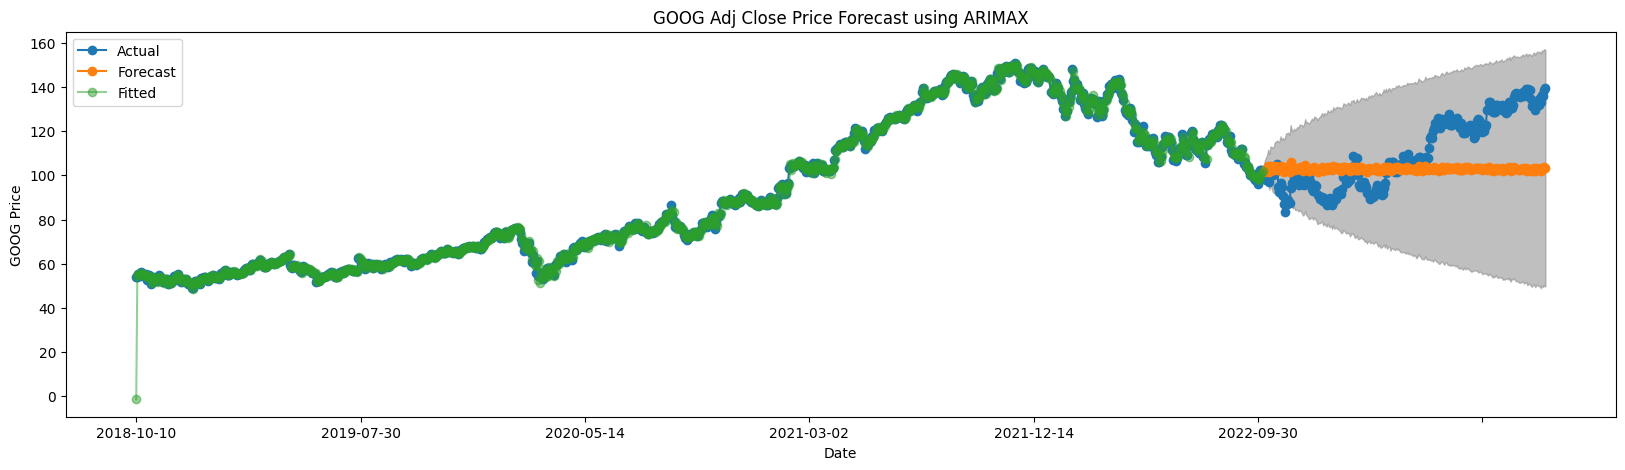

In [98]:
pred = arimax.get_forecast(steps=252, exog=x_test).predicted_mean
ci = arimax.get_forecast(steps=252, exog=x_test).conf_int()

df['GOOG'].plot(marker='o', figsize=(20, 5), label='Actual')
pred.plot(marker='o', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='grey', alpha=0.5)
arimax.fittedvalues.plot(marker='o', label='Fitted', alpha=0.5)
plt.title('GOOG Adj Close Price Forecast using ARIMAX')
plt.xlabel('Date')
plt.ylabel('GOOG Price')
plt.legend()
plt.show()

In [99]:
 print('MAPE:',mean_absolute_percentage_error(y_test, pred))
print('MAE:',mean_absolute_error(y_test, pred))
print('MSE:',mean_squared_error(y_test, pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test, pred)))

MAPE: 0.12290144572037337
MAE: 14.357715595649143
MSE: 314.23148186471616
RMSE: 17.726575582010085


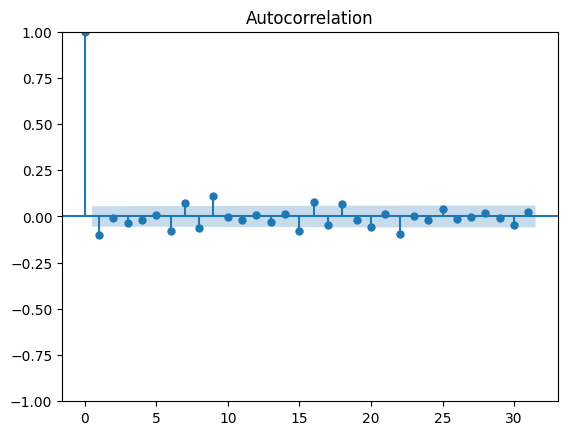

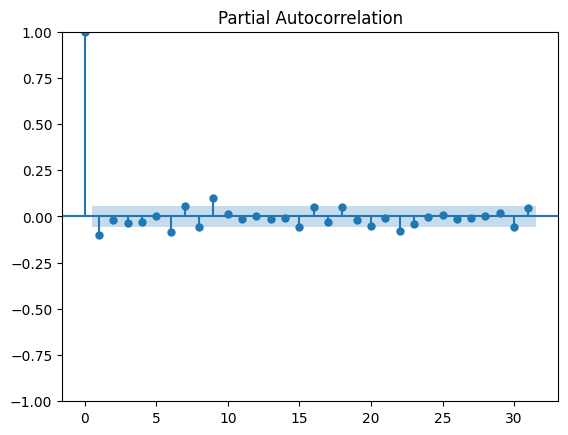

In [100]:
plot_acf(df['GOOG_return'])
plot_pacf(df['GOOG_return'])
plt.show()

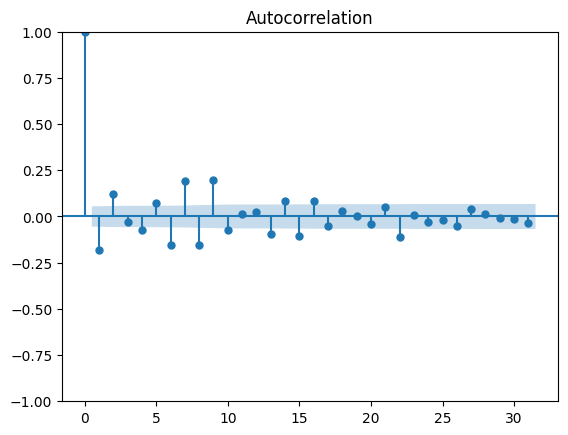

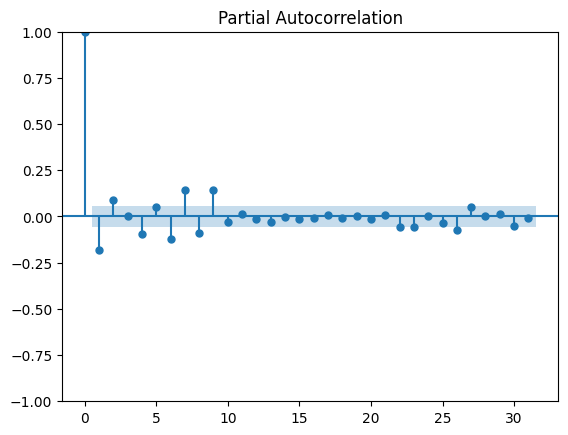

In [101]:
plot_acf(df['SP500_return'])
plot_pacf(df['SP500_return'])
plt.show()

In [102]:
arimax_1 = SARIMAX(endog = df['GOOG_return'].iloc[:1005], exog = df['SP500_return'].iloc[:1005], order = (1,0,1)).fit()
print(arimax_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            GOOG_return   No. Observations:                 1005
Model:               SARIMAX(1, 0, 1)   Log Likelihood                3005.508
Date:                Sat, 09 Dec 2023   AIC                          -6003.016
Time:                        23:21:06   BIC                          -5983.365
Sample:                             0   HQIC                         -5995.549
                               - 1005                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
SP500_return     1.0004      0.000   2639.850      0.000       1.000       1.001
ar.L1           -0.0144      1.054     -0.014      0.989      -2.081       2.052
ma.L1           -0.0144      1.054     -0.01

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


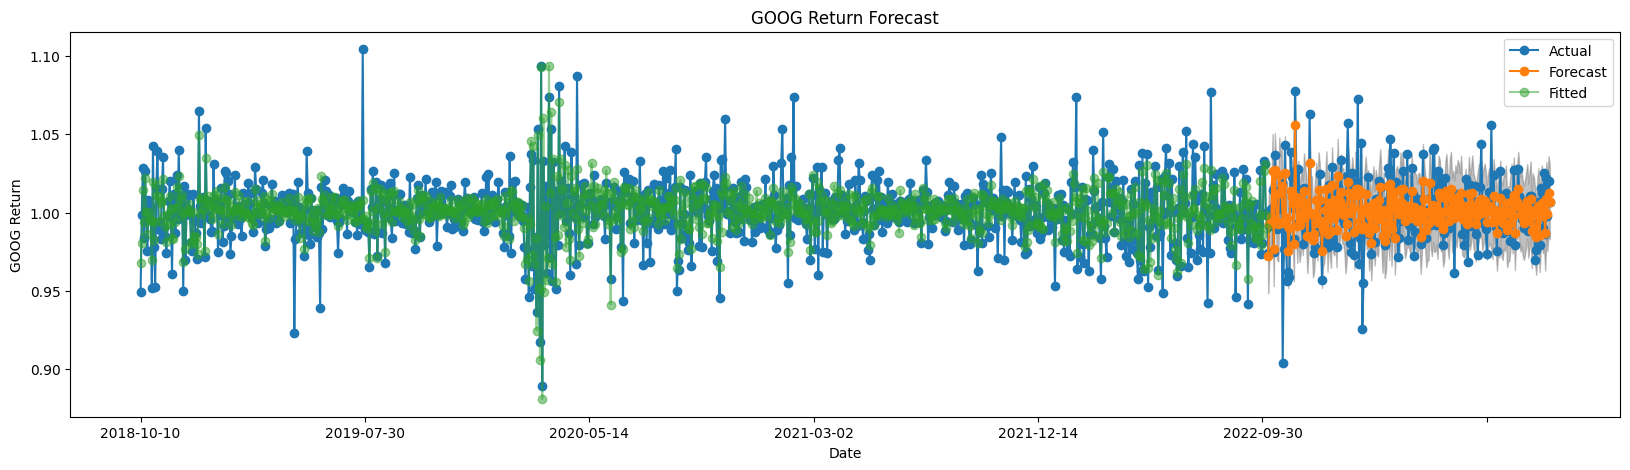

In [103]:
pred_1 = arimax_1.get_forecast(steps=252, exog=df['SP500_return'].iloc[1005:]).predicted_mean
ci_1 = arimax_1.get_forecast(steps=252, exog=df['SP500_return'].iloc[1005:]).conf_int()

df['GOOG_return'].plot(marker='o', figsize=(20, 5), label='Actual')
pred_1.plot(marker='o', label='Forecast')
plt.fill_between(ci_1.index, ci_1.iloc[:, 0], ci_1.iloc[:, 1], color='grey', alpha=0.5)
arimax_1.fittedvalues.plot(marker='o', label='Fitted', alpha=0.5)
plt.title('GOOG Return Forecast')
plt.xlabel('Date')
plt.ylabel('GOOG Return')
plt.legend()
plt.show()

In [104]:
print('MAPE:',mean_absolute_percentage_error(df['GOOG_return'].iloc[1005:], pred_1))
print('MAE:',mean_absolute_error(df['GOOG_return'].iloc[1005:], pred_1))
print('MSE:',mean_squared_error(df['GOOG_return'].iloc[1005:], pred_1))
print('RMSE:',np.sqrt(mean_squared_error(df['GOOG_return'].iloc[1005:], pred_1)))

MAPE: 0.011362100518238495
MAE: 0.011370790439024977
MSE: 0.0002607511886752417
RMSE: 0.016147792068120077


In [105]:
# add back google adj close price on 2018-10-09
df = pd.concat([
    pd.DataFrame({'GOOG': [goog_2018_10_09]}, index=['2018-10-09']),
    df
])

In [106]:
# calculate predicted GOOG adj close price with predicted return
df['GOOG_return_pred'] = None
df['GOOG_return_pred'].iloc[1:1006] = arimax_1.fittedvalues
df['GOOG_return_pred'].iloc[1006:] = pred_1

df['GOOG_pred'] = df['GOOG'].iloc[0]
for i in range(1, len(df)):
  df['GOOG_pred'].iloc[i] = df['GOOG_pred'].iloc[i-1] * df['GOOG_return_pred'].iloc[i]

<ipython-input-106-e2af5eb42faa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GOOG_return_pred'].iloc[1:1006] = arimax_1.fittedvalues
<ipython-input-106-e2af5eb42faa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GOOG_return_pred'].iloc[1006:] = pred_1
<ipython-input-106-e2af5eb42faa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GOOG_pred'].iloc[i] = df['GOOG_pred'].iloc[i-1] * df['GOOG_return_pred'].iloc[i]


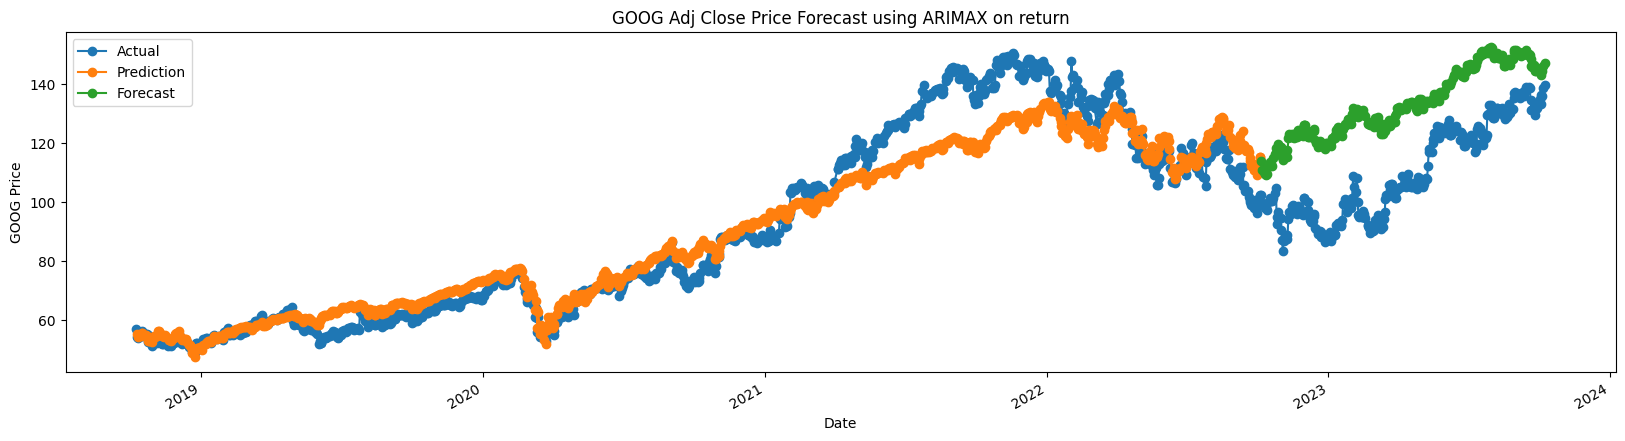

In [107]:
df.index = pd.to_datetime(df.index)
df['GOOG'].plot(marker='o', figsize=(20, 5), label='Actual')
df['GOOG_pred'].iloc[1:1005].plot(marker='o', label='Prediction')
df['GOOG_pred'].iloc[1005:].plot(marker='o', label='Forecast')
plt.title('GOOG Adj Close Price Forecast using ARIMAX on return')
plt.xlabel('Date')
plt.ylabel('GOOG Price')
plt.legend()
plt.show()

In [108]:
print('MAPE:',mean_absolute_percentage_error(df['GOOG'].iloc[1005:], df['GOOG_pred'].iloc[1005:]))
print('MAE:',mean_absolute_error(df['GOOG'].iloc[1005:], df['GOOG_pred'].iloc[1005:]))
print('MSE:',mean_squared_error(df['GOOG'].iloc[1005:], df['GOOG_pred'].iloc[1005:]))
print('RMSE:',np.sqrt(mean_squared_error(df['GOOG'].iloc[1005:], df['GOOG_pred'].iloc[1005:])))

MAPE: 0.2216022285088852
MAE: 23.138150966351144
MSE: 589.577867765347
RMSE: 24.28122459361033


In [109]:
# if we set last day of train data as start point
df['GOOG_pred_1'] = None
df['GOOG_pred_1'].iloc[1005] = df['GOOG'].iloc[1005]
for i in range(1006, len(df)):
  df['GOOG_pred_1'].iloc[i] = df['GOOG_pred_1'].iloc[i-1] * df['GOOG_return_pred'].iloc[i]

<ipython-input-109-f0f409917940>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GOOG_pred_1'].iloc[1005] = df['GOOG'].iloc[1005]
<ipython-input-109-f0f409917940>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GOOG_pred_1'].iloc[i] = df['GOOG_pred_1'].iloc[i-1] * df['GOOG_return_pred'].iloc[i]


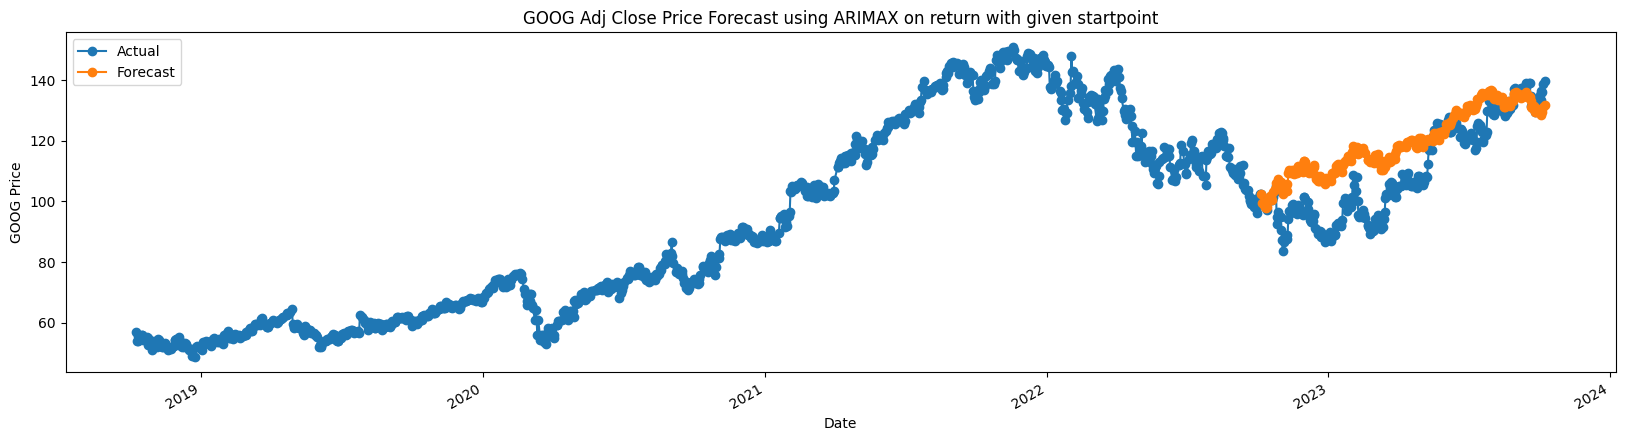

In [110]:
df['GOOG'].plot(marker='o', figsize=(20, 5), label='Actual')
df['GOOG_pred_1'].iloc[1005:].plot(marker='o', label='Forecast')
plt.title('GOOG Adj Close Price Forecast using ARIMAX on return with given startpoint')
plt.xlabel('Date')
plt.ylabel('GOOG Price')
plt.legend()
plt.show()

In [111]:
print('MAPE:',mean_absolute_percentage_error(df['GOOG'].iloc[1005:], df['GOOG_pred_1'].iloc[1005:]))
print('MAE:',mean_absolute_error(df['GOOG'].iloc[1005:], df['GOOG_pred_1'].iloc[1005:]))
print('MSE:',mean_squared_error(df['GOOG'].iloc[1005:], df['GOOG_pred_1'].iloc[1005:]))
print('RMSE:',np.sqrt(mean_squared_error(df['GOOG'].iloc[1005:], df['GOOG_pred_1'].iloc[1005:])))

MAPE: 0.10076359276492367
MAE: 10.098894469827604
MSE: 148.58428585449613
RMSE: 12.18951540687718
